># **PROJECT**:**MOVIE** **GENRE** **CLASSIFICATION**

>**Introduction**

Here is a machine learning model that can predict the genre of a
movie based on its plot summary or other textual information. I have used TF-IDF technique with classifiers
such as Naive Bayes, Logistic Regression, and Support Vector
Machines.

>**Load** **libraries**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import shutil
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

># **Data Collection**

**Load Datasets**

In [6]:
train_path = "train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')


In [7]:
test_path = "test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id' , 'Title', 'Description'], engine='python')

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7935 entries, 1 to 7935
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        7935 non-null   object
 1   Genre        7935 non-null   object
 2   Description  7935 non-null   object
dtypes: object(3)
memory usage: 248.0+ KB


In [9]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [10]:
train_data.shape

(7935, 3)

In [11]:
train_data.duplicated().sum()

0

  ># **Data Preprocessing**

In [12]:
#this is function in which stopword and porterStemmer is performed
def preprocess_text(data):
    stop_words = set(stopwords.words("english"))
    data["Description"] = data["Description"].str.lower()
    data["Description"] = data["Description"].apply(lambda x: " ".join(word for word in word_tokenize(x) if word not in stop_words))

    stemmer = PorterStemmer()
    data['Description'] = data['Description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
    return data

In [13]:
#preprocess train and test data
preprocessed_train_data = preprocess_text(train_data)

preprocessed_test_data = preprocess_text(test_data)

># **Data** **Exploration**

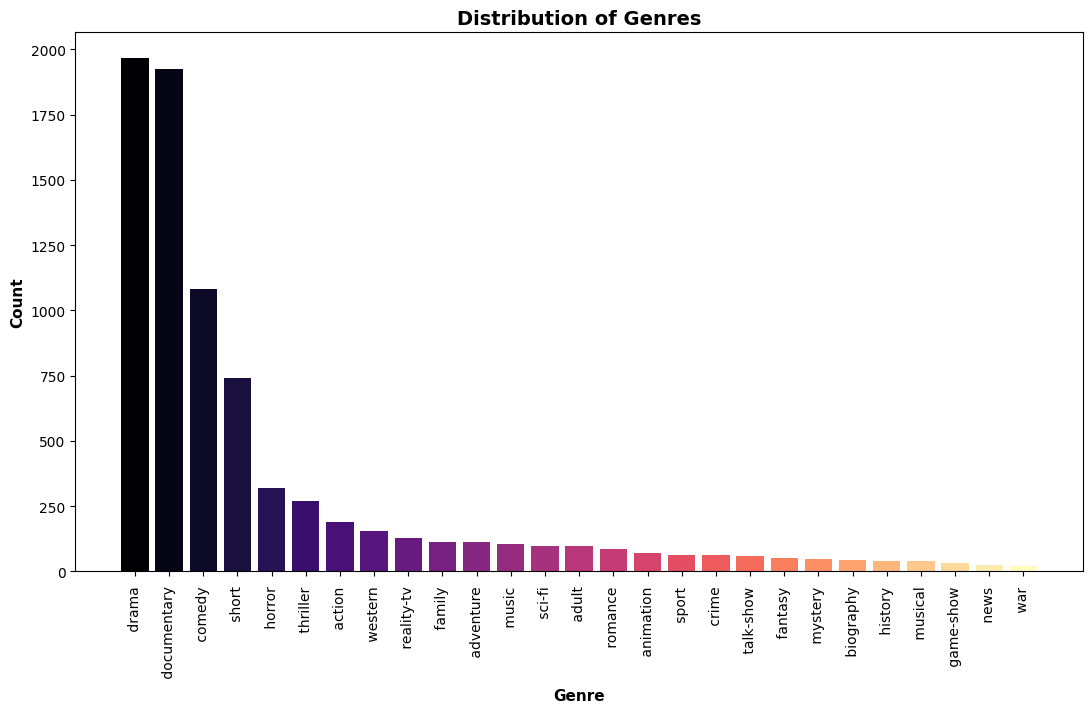

In [14]:
#Genre distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 7))
genre_counts = train_data['Genre'].value_counts()
colors = plt.cm.magma((np.linspace(0, 1, len(genre_counts))))
plt.bar(genre_counts.index, genre_counts, color=colors)
plt.xlabel('Genre', fontsize=11, fontweight='bold')
plt.ylabel('Count', fontsize=11, fontweight='bold')
plt.title('Distribution of Genres', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.show()

># **Feature Extraction**

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  #can adjust the number of features
train_X = tfidf_vectorizer.fit_transform(train_data['Description'])
test_X = tfidf_vectorizer.fit_transform(test_data['Description'])

 ># **Data Splitting**

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(train_X, train_data['Genre'], test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

># **Model Selection and Evaluation**

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Create instances of the models
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000)
svm_model = SVC(kernel='linear')
rf_model = RandomForestClassifier(n_estimators=100)


> **MEAN** **ACCURACY** (**Cross** **validation**)

In [18]:
# Define the number of folds (K)
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# List of models
models = [nb_model, lr_model, svm_model, rf_model]

# Dictionary to store evaluation results for each model
model_results = {}

for model in models:
    model_name = type(model).__name__

    # Perform cross-validation for the model and calculate accuracy scores
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    # Calculate mean accuracy score across folds
    mean_accuracy = scores.mean()

    # Create a model evaluation dictionary
    evaluation_results = {
        "Model": model_name,
        "Mean Accuracy (Cross-Validation)": mean_accuracy
    }

    # Store the evaluation results for the model
    model_results[model_name] = evaluation_results

# Create a DataFrame with evaluation results for all models
results_df = pd.DataFrame(list(model_results.values()))

# Print the evaluation results for all models
for _, row in results_df.iterrows():
    print("Evaluation Results for", row["Model"])
    for metric, value in row.items():
        print(f"{metric}: {value}")

Evaluation Results for MultinomialNB
Model: MultinomialNB
Mean Accuracy (Cross-Validation): 0.427981608971708
Evaluation Results for LogisticRegression
Model: LogisticRegression
Mean Accuracy (Cross-Validation): 0.4855979111424656
Evaluation Results for SVC
Model: SVC
Mean Accuracy (Cross-Validation): 0.512964539697213
Evaluation Results for RandomForestClassifier
Model: RandomForestClassifier
Mean Accuracy (Cross-Validation): 0.44832688674272836


>**Best Model**

In [19]:
best_model_name = max(model_results, key=lambda k: model_results[k]["Mean Accuracy (Cross-Validation)"])
print("Best Model:", best_model_name)

Best Model: SVC


>**Best Model Training**

In [20]:
# Create a dictionary to map model names to model instances
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier()
}

# Instantiate the best model class and fit it on the entire training data
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

SVC()

**Model Evaluation**

In [21]:
from sklearn.metrics import classification_report

# Use the fitted best model's predict() method to generate predictions on the test data
y_pred = best_model.predict(X_valid)
print(classification_report(y_valid, y_pred))

               precision    recall  f1-score   support

      action        0.00      0.00      0.00        28
       adult        0.00      0.00      0.00        20
   adventure        0.00      0.00      0.00        10
   animation        0.00      0.00      0.00        10
   biography        0.00      0.00      0.00         7
      comedy        0.64      0.32      0.42       155
       crime        0.00      0.00      0.00         9
 documentary        0.59      0.87      0.70       319
       drama        0.41      0.90      0.56       287
      family        0.00      0.00      0.00        19
     fantasy        0.00      0.00      0.00         6
   game-show        1.00      0.33      0.50         3
     history        0.00      0.00      0.00         9
      horror        1.00      0.09      0.17        44
       music        0.00      0.00      0.00        17
     musical        0.00      0.00      0.00         5
     mystery        0.00      0.00      0.00         7
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model Testing**

In [22]:

y_test_pred = best_model.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.47103274559193953


># **Make Predictions on the Test Dataset**

In [23]:
X_test_predictions = best_model.predict(test_X)
test_data['Predicted_Genre'] = X_test_predictions

In [24]:
print(test_data.head())

   Id                          Title  \
0   1          Edgar's Lunch (1998)    
1   2      La guerra de papá (1977)    
2   3   Off the Beaten Track (2010)    
3   4        Meu Amigo Hindu (2015)    
4   5             Er nu zhai (1955)    

                                         Description Predicted_Genre  
0  l.r . brane love life - car , apart , job , es...          drama   
1  spain , march 1964 : quico naughti child three...    documentary   
2  one year life albin famili shepherd north tran...    documentary   
3  father die , n't spoken brother 10 year seriou...    documentary   
4  known intern martial art superstar , bruce lee...          drama   
